Image Classification with CNNs

In [1]:
# import libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
# define the parameters for data (input) normalization
# These values are pre-computed and available in the mean
# dataset website
mean_gray = 0.1307 
stddev_gray = 0.3081

# input[channel] = ( (input[channel] - mean[channel]) / std[channel])

transforms = transforms.Compose([transforms.ToTensor(), # composes a set of transformations (we first convert images to a tensor and then normalize the tensor)
                                 transforms.Normalize((mean_gray),(stddev_gray))]) # Normalize the input images (the dataset)

# Now we load/download the datasets for train and test

train_dataset = datasets.MNIST(root = "./data", # where to save the dataset
                                train=True, # is it for training purposes?
                                transform=transforms, # how to transform the image to a tensor?
                                download=True) # Do we want to download it?

test_dataset = datasets.MNIST(root = "./data",
                                train=False, # This will download the test dataset
                                transform=transforms)
# in the test_dataset it is not necessary to download the dataset
# rather we will LOAD IT FROM PYTORCH

Visualize some of the dataset images

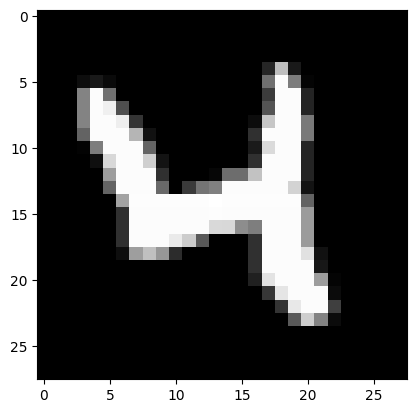

In [3]:
import matplotlib.pyplot as plt # needed for image visualization
random_img = train_dataset[20][0].numpy() * stddev_gray + mean_gray # image at index #20 the [0] element is the image, while the [1] element would be the label
# remember that we need to convert the image to a numpy array to visualize it and we also have to denormalize it for visualization purposes
plt.imshow(random_img.reshape(28,28), cmap= "gray") # show the image with matplotlib, we need to reshape the image back to its original size (28 x 28)


In [4]:
# print the corresponding label, just to check
print(train_dataset[20][1])

4


Create the Dataloader (we need to know the batch size)

In [5]:
import torch.utils
import torch.utils.data


batch_size = 100
train_load = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True) # shuffle the order of the images

test_load = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False) # No need to shuffle since we are just testing

In [6]:
# Visualize the train dataset to understand what is happening
len(train_dataset)

60000

In [7]:
# Visualize the train loader to understand what is happening

len(train_load)

600

In [8]:
# Visualize the test dataset to understand what is happening
len(test_dataset)

10000

In [9]:
# Visualize the test loader to understand what is happening

len(test_load)

100

Building the CNN (Starting with defining the class)

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Same padding --> input_size = output_size
        # Same padding = (filter_size - 1) / 2
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1) # defining the first convolutional layer, input channel is 1 becasue grayscale images, out_channels is the number of filters/feature maps we want, kernel_size refers to the size of each filter for the convolution operation, stride is the no of pixels it moves in the convolution operation we use 1 to avoid downsampling, padding we use the formula (filter_size - 1 / 2)
        # The output size of each of the 8 feature maps:
        # [(input_size - filter_size + 2(padding))/ stride] + 1 = [(28 - 3 + 2)/1] + 1 = 28
        # Now we apply batch normalization to the first layer
        self.batchnorm1 = nn.BatchNorm2d(8) # 8 refers to the no of feature maps
        # Activation function for all conv layer
        self.relu = nn.ReLU() 
        # Maxpooling for all layers
        self.maxpool = nn.MaxPool2d(kernel_size=2) # reduce by 2
        # The output size = 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        # Output size of each of 32 feature maps = 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        # After this second batch norm we perform the same max pooling again thus
        # reducing the size of the feature maps to 7x7
        # Finally we specify the linear layers for when we flatten out the feature maps
        # First linear layer size = 7 x 7 x 32 = 1568
        self.fc1 = nn.Linear(1568,600) # thus input size is 1568
        # It is recommended to apply dropout between linear layers to avoid overfitting
        self.dropout = nn.Dropout(p=0.5) # p is probability of dropout, in this case 50%
        # Final linear layer is the classifictaion layer with a size of 10
        self.fc2 = nn.Linear(600,10)

    def forward(self,x): # forward propagation function (x is input images)
        # Convolutional part
        # first conv
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        # first max pooling
        out = self.maxpool(out)
        # second conv
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        # second max pooling
        out = self.maxpool(out)
        # Flatten the output (7x7x32) = 1568
        # remember we also need to  take into account the batch size
        # in this case its 100, so we go (100 rows,1568 columns)
        out = out.view(-1,1568) # we can use -1 instead of 100
        # linear part
        # first linear layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        # second linear layer (output)
        out = self.fc2(out)
        return out
        

Build the object, define optimizer and loss function

In [16]:
# instance an object of the model class
model = CNN()
# check if GPU is available
CUDA = torch.cuda.is_available()

if CUDA: # if we have a gpu move the model there
    model = model.cuda()

# define loss function (We use cross entropy loss)

loss_fn = nn.CrossEntropyLoss() # we use it because we are gonna preddict probabilities with softmax

# define the optimizer

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # model.parameters() are the weights of the model


(Optional) Understanding what is happening in the propagation

In [28]:
iteration = 0
correct = 0

for i,(inputs,labels) in enumerate(train_load):

    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()

    print("For one iteration, this is what happens\n")
    # Each teansor propagated through the network should be 4d (batch_size, channles, rows, cols)
    print("Input Shape:", inputs.shape)
    print("First dimension is batch size = 100, second is # of channels = 1, \nthe other two are the dimensions of the image = 28 x 28,\nwe always need 4d tensors to propagate")
    print("\nLabels Shape:", labels.shape)
    output = model(inputs)
    print("Output Shape:", output.shape)
    _,predicted = torch.max(output,1)
    print("Predicted Shape:", predicted.shape)
    print("Predicted Tensor:")
    print(predicted)
    correct += (predicted == labels).sum()
    print("correct predictions:", correct)
    break

For one iteration, this is what happens

Input Shape: torch.Size([100, 1, 28, 28])
First dimension is batch size = 100, second is # of channels = 1, 
the other two are the dimensions of the image = 28 x 28,
we always need 4d tensors to propagate

Labels Shape: torch.Size([100])
Output Shape: torch.Size([100, 10])
Predicted Shape: torch.Size([100])
Predicted Tensor:
tensor([6, 0, 7, 6, 6, 5, 9, 6, 1, 6, 5, 6, 0, 5, 6, 6, 6, 6, 1, 6, 8, 6, 5, 6,
        0, 5, 6, 1, 7, 6, 9, 0, 6, 0, 7, 6, 6, 6, 6, 9, 6, 0, 7, 6, 9, 6, 0, 6,
        6, 6, 0, 5, 5, 5, 5, 6, 6, 6, 0, 6, 1, 0, 6, 6, 6, 6, 9, 6, 6, 5, 5, 0,
        6, 5, 0, 6, 5, 6, 6, 1, 5, 7, 5, 4, 6, 9, 4, 5, 0, 0, 6, 5, 5, 6, 6, 0,
        5, 6, 0, 1], device='cuda:0')
correct predictions: tensor(16, device='cuda:0')


Train the CNN

In [ ]:
# training the CNN
num_epochs = 10 

# loss and accuracy lists
train_loss = []
train_accuracy = []

test_loss = []
test_accuracy = []

# as for the training

for epoch in range(num_epochs):
    correct = 0 # number of correct predictions in epoch
    iterations = 0 # number of iterations in epoch
    iter_loss = 0.0 # loss for 1 iteration

    # we need to set the model in "training mode" because we used dropout and batch norm

    model.train()

    for i,(inputs,labels) in enumerate(train_load):

        if CUDA: # pass inputs and labels to gpu
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs) # pass the batch through the network
        loss = loss_fn(outputs,labels) # calculate the loss (Cross Entropy Loss)
        iter_loss += loss.item() # save the loss for this specific iteration

        optimizer.zero_grad() # clear the gradient for the backpropagation
        loss.backward() # perform backpropagation
        optimizer.step() # update the weights

        _,predicted = torch.max(outputs,1) # get the actual prediction (index) from the probability distribution
        correct += (predicted == labels).sum().item() # get the amount of correct predictions in this iteration
        
        iterations += 1

    # save the results in the lists we created (once for each epoch)

    train_loss.append(iter_loss/iterations)
    train_accuracy.append(correct / len(train_dataset))
